In [1]:
import os
import sys
import inspect

import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider, fixed

In [2]:
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
print(f"{parent_dir} was added to sys.path")

/Users/g.gospodinov/Desktop/IntTool was added to sys.path


In [3]:
from IntTool.utils import *

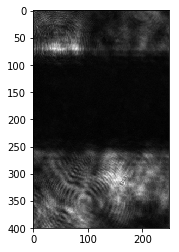

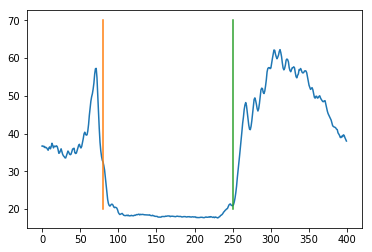

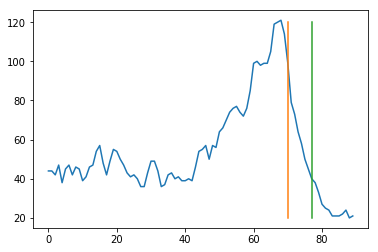

In [4]:
wire = rotate_image(read_image('./wire150mkm.png'), 35, 800, 1200, 1250, 1500)
plt.imshow(wire, cmap='gray')
plt.show()

down_limit = 80
up_limit = 250
plt.plot(wire.mean(1))
plt.plot([down_limit, down_limit], [20, 70])
plt.plot([up_limit, up_limit], [20, 70])
plt.show()

shift = 50

plt.plot(wire[74 - 20 - shift:74 + 20, 47])
plt.plot([shift + 20, shift + 20], [20, 120])
plt.plot([shift + 27, shift + 27], [20, 120])
plt.show()

In [5]:
wavelength = 0.4 # mkm
real_size = 150 # mkm
pixel_size = 5.86 # mkm

magnification = (up_limit - down_limit) * pixel_size / real_size
print('magnification =', magnification)

mkm_per_pixel = pixel_size / magnification
print('mkm_per_pixel =', mkm_per_pixel)

magnification = 6.641333333333334
mkm_per_pixel = 0.8823529411764706


In [59]:
angle = 45

IN_FOLDER = './data to prepare/{}_deg/'.format(angle)
back_name = 'int.png'
mode = 'ns'
int_name = 'int_{}.png'.format(mode)
################################
OUT_FOLDER = './prepared_data'

delay_folder = input('delay_folder: ')
int_prefix = '_'.join(delay_folder.split('_')[-1])

IN_PATH = os.path.join(IN_FOLDER, delay_folder)

OUT_PATH = os.path.join(OUT_FOLDER, delay_folder)

if not os.path.exists(OUT_PATH):
    os.mkdir(OUT_PATH)

delay_folder: ASE#ns#2ps#8


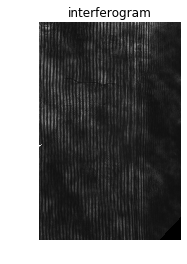

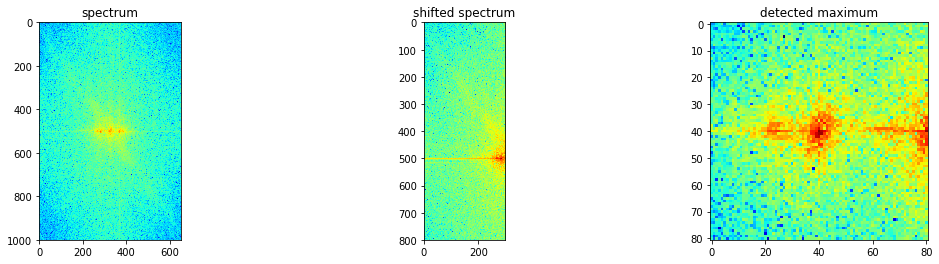

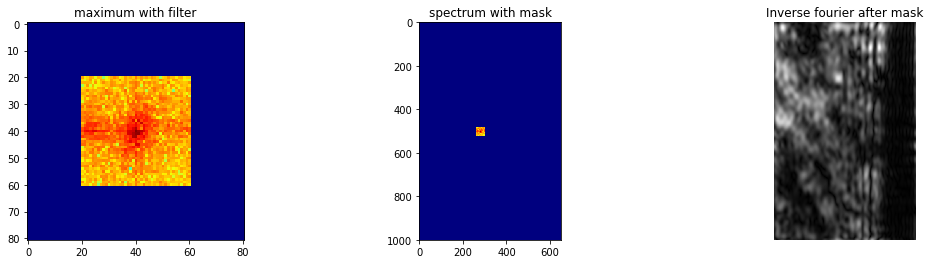

In [60]:
# 45 deg

interferogram = read_image(os.path.join(IN_PATH, int_name))
background = read_image(os.path.join(IN_PATH, back_name))

interferogram = rotate_image(interferogram, 45 + 2, 500, 2000 - 500, 1000, 1650)
background = rotate_image(background, 45 + 2, 500, 2000 - 500, 1000, 1650)

mask_size = (20,20)#(1250 * 0.01, 1250 * 0.01)
area_to_show = (40, 40)
gauss_mask = False

mask_center = interferogram_describe(interferogram, mask_size, area_to_show, gauss_mask=gauss_mask, shift_x=300, shift_y=800)

In [61]:
mask = []
target_position = 0
x = np.arange(interferogram.shape[1])
y = np.arange(interferogram.shape[0])

@interact(img=fixed(interferogram),
          x1 = IntSlider(min=x[0], max=x[-1], step=10, continuous_update=True, value=200),
          x2 = IntSlider(min=x[0], max=x[-1], step=10, continuous_update=True, value=475),
          y1 = IntSlider(min=y[0], max=y[-1], step=10, continuous_update=True, value=100 + 200),
          y2 = IntSlider(min=y[0], max=y[-1], step=10, continuous_update=True, value=900 - 200),
          target = IntSlider(min=x[0], max=x[-1], step=10, continuous_update=True, value=500),
          color=fixed('red'),
          target_color=fixed('green')
         )
def search_mask(img, x1, x2, y1, y2, target, color, target_color):
    plt.figure(figsize=(20, 10))
    plt.imshow(img, cmap='gray', vmin=img.min() * 1.5, vmax=img.max() * 0.7)
    plt.plot([x1, x1], [0, img.shape[0] - 1], color)
    plt.plot([x2, x2], [0, img.shape[0] - 1], color)
    plt.plot([0, img.shape[1] - 1], [y1, y1], color)
    plt.plot([0, img.shape[1] - 1], [y2, y2], color)
    plt.plot([target, target], [0, img.shape[0] - 1], target_color)
    plt.savefig(os.path.join(OUT_PATH,'./crop_position_{}.png'.format(delay_folder)))
    plt.show()
    Intensity = complex_abs(
        inverse_fourier(
            apply_mask(fourier(interferogram), mask_center, mask_size, gauss=gauss_mask)
        )
    )
    plt.figure(figsize=(20, 10))
    plt.imshow(Intensity, cmap='gray')
    plt.plot([x1, x1], [0, Intensity.shape[0] - 1], color)
    plt.plot([x2, x2], [0, Intensity.shape[0] - 1], color)
    plt.plot([0, Intensity.shape[1] - 1], [y1, y1], color)
    plt.plot([0, Intensity.shape[1] - 1], [y2, y2], color)
    plt.plot([target, target], [0, img.shape[0] - 1], target_color)
    plt.show()
    global mask
    mask = [y1, y2, x1, x2]
    global target_position
    target_position = target

interactive(children=(IntSlider(value=200, description='x1', max=649, step=10), IntSlider(value=475, descripti…

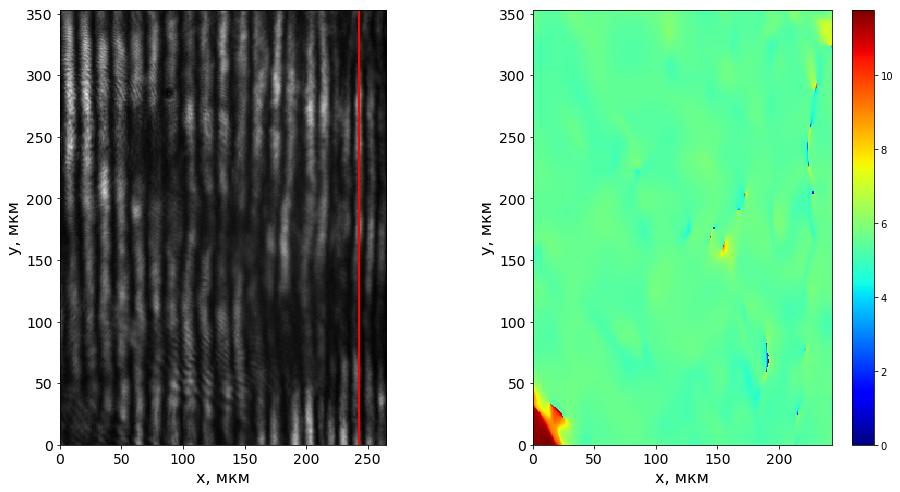

In [62]:
reconstructed_phase = phase_from_plasma_background(
    background, 
    interferogram, 
    mask, 
    mask_center, 
    mask_size, 
    mask_gauss=gauss_mask,
    remove=False
)
cleared_phase = reconstructed_phase# - reconstructed_phase[-10:].mean(0)
cleared_phase -= cleared_phase.min()

y1, y2, x1, x2 = mask

crop_position = (x2 - x1) * mkm_per_pixel
int_frame = interferogram[y1:y2, x1:target_position]

plt.imshow(
    int_frame, 
    cmap='gray', 
    extent=[0, (target_position - x1) * mkm_per_pixel, 0, (y2 - y1) * mkm_per_pixel]
)
plt.xlabel(u'x, мкм', fontsize=12)
plt.ylabel(u'y, мкм', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.axis("off")
plt.savefig(
    os.path.join(OUT_PATH, './interferogram_{}.png'.format(delay_folder)),
    dpi=200,
    bbox_inches='tight',
    pad_inches=0
)
plt.close()

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(int_frame, cmap='gray', extent=[0, (target_position - x1) * mkm_per_pixel, 0, (y2 - y1) * mkm_per_pixel])
plt.plot([crop_position, crop_position], [0, (int_frame.shape[0] - 1) * mkm_per_pixel], color='red', linewidth=2)
plt.xlabel(u'x, мкм', fontsize=16)
plt.ylabel(u'y, мкм', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1, 2, 2)
plt.imshow(cleared_phase, cmap='jet', extent=[0, (x2 - x1) * mkm_per_pixel, 0, (y2 - y1) * mkm_per_pixel])
plt.colorbar()
plt.xlabel(u'x, мкм', fontsize=16)
plt.ylabel(u'y, мкм', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(os.path.join(OUT_PATH, './int_vs_phase_{}.png'.format(delay_folder)), dpi=200)
plt.show()

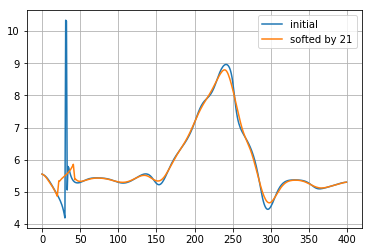

In [58]:
points_to_soft = 21
row = -1

softed_phase = np.array([soft(cleared_phase[:, i], n=points_to_soft) for i in range(cleared_phase.shape[1])]).T


plt.plot(cleared_phase[:,row], label='initial')
plt.plot(softed_phase[:,row], label=f'softed by {points_to_soft}')
plt.grid()
plt.legend()
plt.show()

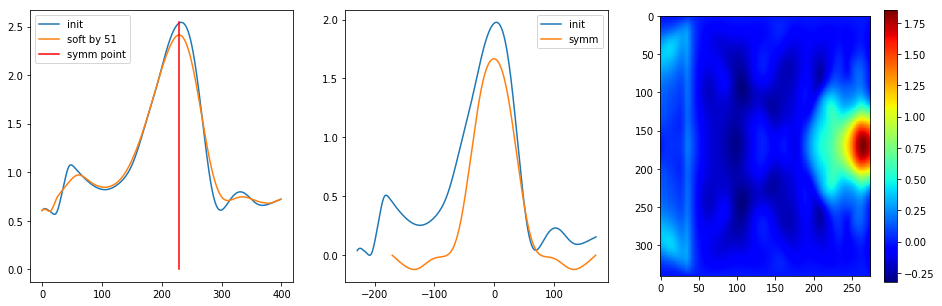

In [43]:
avg_points = 51
index = -1

center_index=soft(softed_phase[:, index], n=avg_points).argmax()
centered = symmetrize(softed_phase[:, index], center_index)
phase_x = np.arange(softed_phase[:, index].size) - center_index
centered_phase_x = np.arange(centered.size) - centered.size / 2
symmetrical_phase = symmetrize_2d(softed_phase, center_index)

plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.plot(softed_phase[:, index], label='init')
plt.plot(soft(softed_phase[:, index], n=avg_points), label='soft by {}'.format(avg_points))
plt.plot([center_index, center_index], [0, np.max(softed_phase[:, index])], 'red', label='symm point')
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(phase_x, softed_phase[:, index] - softed_phase[:, index].min(), label='init')
plt.plot(centered_phase_x, symmetrical_phase[:, index], label='symm')
plt.legend()

plt.subplot(1, 3, 3)
plt.imshow(symmetrical_phase, cmap='jet')
plt.colorbar()
plt.show()

100%|██████████| 21/21 [00:08<00:00,  2.42it/s]


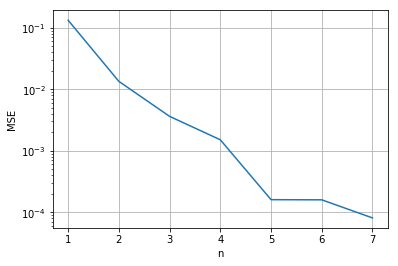

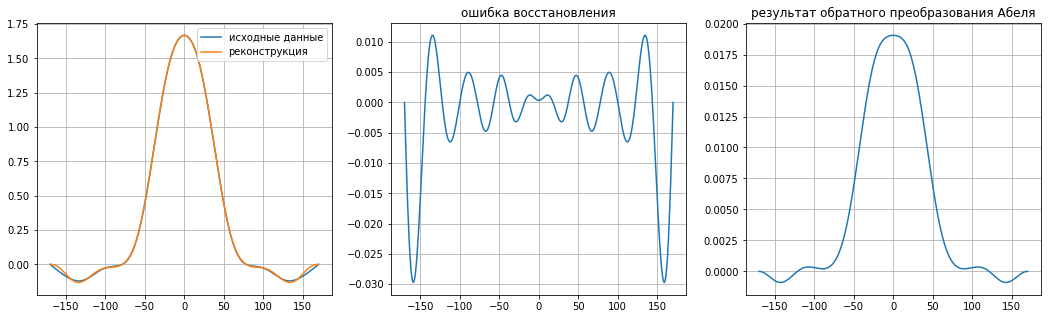

100%|██████████| 275/275 [00:01<00:00, 148.96it/s]


In [46]:
abel_result = abel_inversion_2d(symmetrical_phase, n_max=7, section_id=-1, path_to_save='./../abel_coefs/')

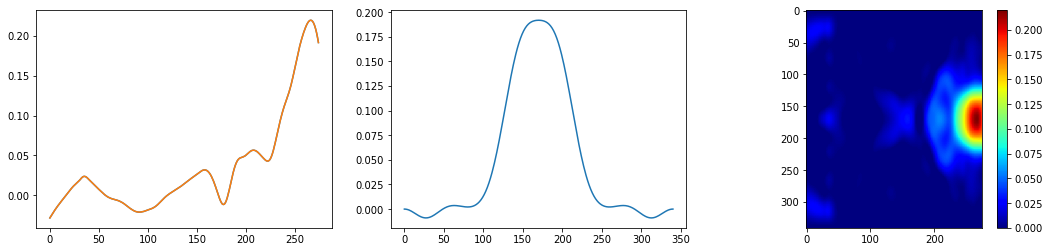

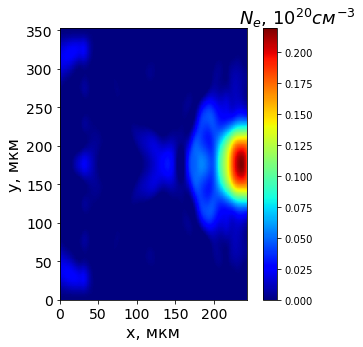

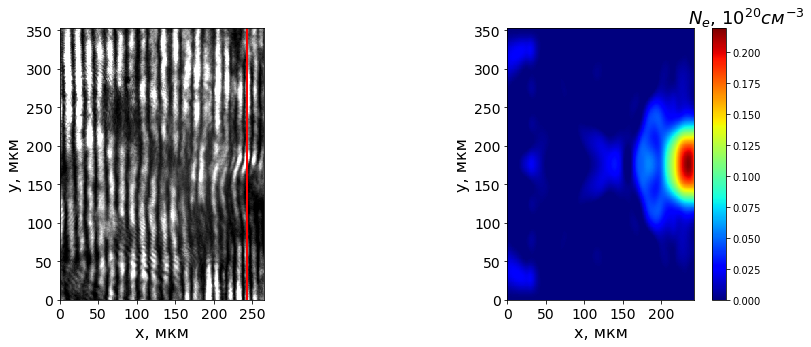

In [48]:
ne = ((1 - (1 - abel_result * wavelength / (2 * np.pi *mkm_per_pixel))**2) * critical_density(wavelength) / 1e20)

plt.figure(figsize=(18,4))
plt.subplot(131)
plt.plot(ne[ne[:, index].argmax(), :])
plt.plot(ne[ne.shape[0]//2,:])
plt.subplot(132)
plt.plot(ne[:,index])

plt.subplot(133)

plt.imshow(
    ne,
    cmap='jet',
    vmin=0,
    vmax=ne.max()
)
plt.colorbar()
plt.show()

plt.figure(figsize=(6, 5))
plt.imshow(
    ne, 
    clim=(0, np.max(ne)),
    cmap='jet', 
    extent=(0,(x2-x1)*mkm_per_pixel,0,(y2-y1)*mkm_per_pixel)
)
plt.xlabel(u'x, мкм', fontsize=16)
plt.ylabel(u'y, мкм', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar = plt.colorbar()
cbar.set_label(r'$N_e$' + r', ' + r'$10^{20} см^{-3}$', rotation=0, labelpad=-15, y=1.08, fontsize=18)
plt.savefig(os.path.join(IN_FOLDER, './ne_{}_deg_{}_ns_{}_mode.png'.format(angle, delay_folder, mode)), format='png', dpi=300)
plt.show()

plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.imshow(
    int_frame, 
    cmap='gray', 
    extent=[0, (target_position - x1) * mkm_per_pixel, 0, (y2 - y1) * mkm_per_pixel],
    vmin=int_frame.min() * 1.2,
    vmax=int_frame.max() * 0.5
)
plt.plot([crop_position, crop_position], [0, (int_frame.shape[0] - 1) * mkm_per_pixel], color='red', linewidth=2)
plt.xlabel(u'x, мкм', fontsize=16)
plt.ylabel(u'y, мкм', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1, 2, 2)
plt.imshow(
    ne, 
    clim=(0, np.max(ne)),
    cmap='jet', 
    extent=(0,(x2-x1)*mkm_per_pixel,0,(y2-y1)*mkm_per_pixel)
)
plt.xlabel(u'x, мкм', fontsize=16)
plt.ylabel(u'y, мкм', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar = plt.colorbar()
cbar.set_label(r'$N_e$' + r', ' + r'$10^{20} см^{-3}$', rotation=0, labelpad=-15, y=1.08, fontsize=18)
plt.savefig(os.path.join(IN_FOLDER, './int_vs_ne_{}_deg_{}_ns_{}_mode.png'.format(angle, delay_folder, mode)), format='png', dpi=300)
plt.show()

In [49]:
ne.max() * 1e20 / critical_density(wavelength)

0.0031478800582057653

In [50]:
# выводим в две колонки результаты вычисленной электронной концентрации в продольном и поперечном сечении

out_folder = './sections/'

if not os.path.exists(out_folder):
    os.mkdir(out_folder)

x_folder = os.path.join(out_folder, 'x/')
z_folder = os.path.join(out_folder, 'z/')

if not os.path.exists(x_folder):
    os.mkdir(x_folder)
if not os.path.exists(z_folder):
    os.mkdir(z_folder)

with open(os.path.join(z_folder, 'Ne(z)_{}_deg_{}_ns_{}_mode.dat'.format(angle, delay_folder, mode)), 'wt') as out_z:
    for k in range(ne.shape[1]):
        out_z.write(str((target_position - x1 - k) * mkm_per_pixel) + '\t' + str(ne[ne[:,index].argmax(), k]) + '\t' + str(ne[ne.shape[0]//2, k]) + '\n')

with open(os.path.join(x_folder, 'Ne(x)_{}_deg_{}_ns_{}_mode.dat'.format(angle, delay_folder, mode)), 'wt') as out_x:
    for k in range(ne.shape[0]):
        out_x.write(str((k - ne.shape[0]//2) * mkm_per_pixel) + '\t' + str(ne[k, index]) + '\n')